# Deep Learning for Chest X-Ray Medical Diagnosis

<img src="images/xray-header-image.png" style="padding-top: 10px;width: 80%;left: 0px;margin-left: 0px;margin-right: 0px;">

For this project, I'm using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), which contains over 100,000 chest X-rays
from 32,717 patients for 14 thoracic diseases.

The goal is to build a multilabel classifier to predict the presence or absence of each condition. I'll work with a ~1,000-image
subset stored locally, and the full dataset is available [here](https://nihcc.app.box.com/v/ChestXray-NIHCC).

This subset includes a CSV of image labels and three preprocessed train, validation, and test splits.
1. nih/train-small-org.csv: ~1,000 training images
2. nih/valid-small.csv: ~200 validation images
3. nih/test.csv: ~400 testing images

This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- Consolidation,
- Edema,
- Effusion,
- Cardiomegaly,
- Atelectasis.

## Table of Contents

- [1. Import Packages and Functions](#1)
- [2. Load the Datasets](#2)
    - [2.1 Loading the Data](#2-1)
    - [2.2 Preventing Data Leakage](#2-2)
    - [2.3 Preparing Images](#2-3)
- [3. Model Development](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
    - [3.2 Get Weighted Loss](#3-2)
    - [3.3 Building the Classifier with DenseNet121 as the Base Model](#3-3)
- [4. Training](#4)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Visualizing Learning with GradCAM](#5-2)

## 1. Import Packages and Functions

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
import med_utils

np.random.seed(42)
tf.random.set_seed(42)

## 2. Load the Datasets


### 2.1 Loading the Data

In [2]:
train_df = pd.read_csv(os.path.join(os.getcwd(), "data", "nih", "train-small-org.csv"))
valid_df = pd.read_csv(os.path.join(os.getcwd(),"data", "nih", "valid-small.csv"))
test_df = pd.read_csv(os.path.join(os.getcwd(),"data", "nih",  "test.csv"))
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
# df_keys = train_df.columns.tolist()
# # Specify the column that identifies the image
# image_column = ['Image', 'PatientId']
#
# # Define all the label columns by excluding the image column
# labels = [col for col in df_keys if col not in image_column]
# labels

In [4]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

### 2.2 Preventing Data Leakage
To prevent data leakage from multiple visits per patient, I'm splitting the dataset at the patient level so each patient appears in only one of the train, validation, or test sets.

In [5]:
# DATA LEAKAGE PREVENTION
def check_for_leakage(df1, df2, patient_col, df1_name="df1", df2_name="df2"):
    """
    Check for patient overlap between two datasets.

    Args:
        df1 (DataFrame): First dataset.
        df2 (DataFrame): Second dataset.
        patient_col (str): Column name containing patient IDs.
        df1_name (str): Optional name for the first dataset (used in result keys).
        df2_name (str): Optional name for the second dataset (used in result keys).

    Returns:
        dict: {
            'leakage': bool,
            'patients_in_both_groups': list,
            'df1_overlap_indices': list,
            'df2_overlap_indices': list
        }
    """

    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = True if any (patients_in_both_groups) else False

    df1_indices = df1[df1[patient_col].isin(patients_in_both_groups)].index.tolist()
    df2_indices = df2[df2[patient_col].isin(patients_in_both_groups)].index.tolist()

    leak_dict = {
        'leakage': leakage,
        'overlapping_patients': patients_in_both_groups,
        f'{df1_name}_overlap_indices': df1_indices,
        f'{df2_name}_overlap_indices': df2_indices
    }

    return leak_dict

In [6]:
train_val_leakage = check_for_leakage(train_df, valid_df, 'PatientId', df1_name="train", df2_name="valid")
train_val_leakage['leakage']

True

In [7]:
train_df.drop(train_val_leakage['train_overlap_indices'], inplace=True)

In [8]:
# Sanity check
ids_valid = valid_df['PatientId'].values
ids_valid_set = set(ids_valid)
# print(f'There are {len(ids_valid_set)} unique patient IDs in the validation set')

ids_train = train_df.PatientId.values
ids_train_set = set(ids_train)
patient_overlap = list(ids_train_set.intersection(ids_valid_set))
n_overlap = len(patient_overlap)

print(f'There are {n_overlap} patient IDs in both the training and validation sets')

There are 0 patient IDs in both the training and validation sets


In [9]:
train_test_leakage = check_for_leakage(train_df, valid_df, 'PatientId', df1_name="train", df2_name="test")
train_test_leakage['leakage']

False

In [10]:
test_val_leakage = check_for_leakage(test_df, valid_df, 'PatientId', df1_name="test", df2_name="valid")
test_val_leakage['leakage']

False

In [11]:
# Inspect data type and check for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 770 entries, 198 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               770 non-null    object
 1   Atelectasis         770 non-null    int64 
 2   Cardiomegaly        770 non-null    int64 
 3   Consolidation       770 non-null    int64 
 4   Edema               770 non-null    int64 
 5   Effusion            770 non-null    int64 
 6   Emphysema           770 non-null    int64 
 7   Fibrosis            770 non-null    int64 
 8   Hernia              770 non-null    int64 
 9   Infiltration        770 non-null    int64 
 10  Mass                770 non-null    int64 
 11  Nodule              770 non-null    int64 
 12  PatientId           770 non-null    int64 
 13  Pleural_Thickening  770 non-null    int64 
 14  Pneumonia           770 non-null    int64 
 15  Pneumothorax        770 non-null    int64 
dtypes: int64(15), object(1)
memor

In [12]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               200 non-null    object
 1   Atelectasis         200 non-null    int64 
 2   Cardiomegaly        200 non-null    int64 
 3   Consolidation       200 non-null    int64 
 4   Edema               200 non-null    int64 
 5   Effusion            200 non-null    int64 
 6   Emphysema           200 non-null    int64 
 7   Fibrosis            200 non-null    int64 
 8   Hernia              200 non-null    int64 
 9   Infiltration        200 non-null    int64 
 10  Mass                200 non-null    int64 
 11  Nodule              200 non-null    int64 
 12  PatientId           200 non-null    int64 
 13  Pleural_Thickening  200 non-null    int64 
 14  Pneumonia           200 non-null    int64 
 15  Pneumothorax        200 non-null    int64 
dtypes: int64(15), object(1)
me

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               420 non-null    object
 1   PatientId           420 non-null    int64 
 2   Cardiomegaly        420 non-null    int64 
 3   Emphysema           420 non-null    int64 
 4   Effusion            420 non-null    int64 
 5   Hernia              420 non-null    int64 
 6   Infiltration        420 non-null    int64 
 7   Mass                420 non-null    int64 
 8   Nodule              420 non-null    int64 
 9   Atelectasis         420 non-null    int64 
 10  Pneumothorax        420 non-null    int64 
 11  Pleural_Thickening  420 non-null    int64 
 12  Pneumonia           420 non-null    int64 
 13  Fibrosis            420 non-null    int64 
 14  Edema               420 non-null    int64 
 15  Consolidation       420 non-null    int64 
dtypes: int64(15), object(1)
me

<a name='2-3'></a>
### 2.3 Preparing Images

With the dataset splits ready, let's configure the model to load and process images using Keras’s [ImageDataGenerator](https://keras.io/preprocessing/image/).

In [14]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """

    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

Building a separate generator for validation and test data.

**Why not reuse the training generator?**

I avoid reusing the training generator for validation or test sets because it applies per-batch normalization. In real-world inference, we process **one image at a time**, and **we shouldn’t rely on test set statistics**. Using batch-level test stats would leak information and inflate performance. So, I'll normalize test and validation images using the **mean and standard deviation computed from the training set**—again, simulating real-world inference conditions. Ideally, we’d compute these stats over the entire training set, but given its size, I’ll use a random sample for efficiency.

In [15]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation and test sets using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        testing_generator (DataFrameIterator) and cv_generator: iterators over test set and validation set respectively
    """

    print("getting train and valid generators...")
    # Get generator to sample the dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir,
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # Get some samples
    batch = next(iter(raw_train_generator))
    data_sample = batch[0]

    # Use sample to fit mean and std for validation and test sets generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # Fit the generator to some samples from the training set
    image_generator.fit(data_sample)

    # Apply generator to validation and test sets
    cv_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    testing_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return cv_generator, testing_generator

With our generator function ready, let's make one generator for our training data and one each of our test and validation datasets.

In [16]:
IMAGE_DIR = os.path.join(os.getcwd(),"data", "nih", "images-small")
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels, sample_size=500)

getting train generator...
Found 770 validated image filenames.
getting train and valid generators...
Found 770 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


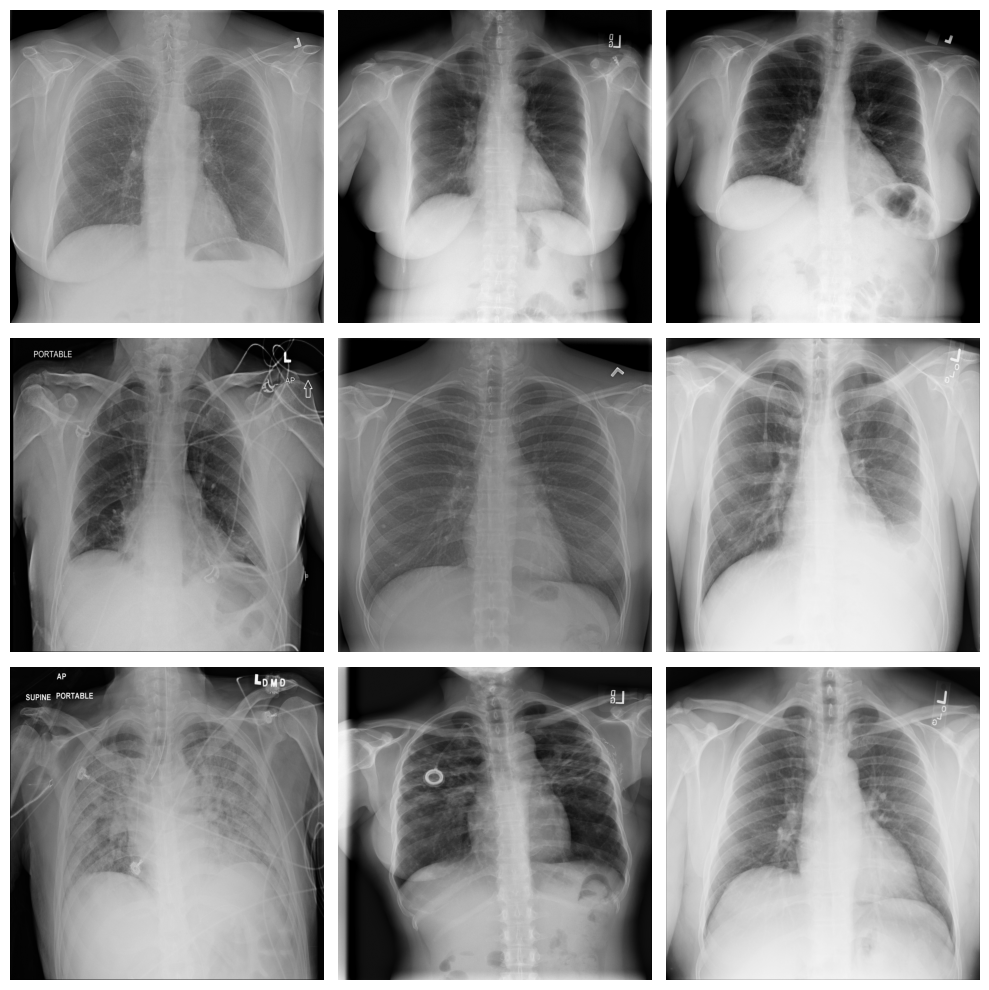

In [17]:
# Visualize some random images
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(IMAGE_DIR, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

## 3. Model Development
A key challenge in medical datasets is severe class imbalance. Before training our model, let's address this to ensure fair learning.

### 3.1 Addressing Class Imbalance

In [18]:
# Function to compute class frequencies
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)

    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels==1, axis=0) / N
    negative_frequencies = np.sum(labels==0, axis=0) / N

    return positive_frequencies, negative_frequencies

In [19]:
train_freq_pos, train_freq_neg = compute_class_freqs(train_df[labels])

In [20]:
# Label distribution
def build_label_distribution_dataframe(data_labels, freq_pos, freq_neg):
    """
    Construct a DataFrame with positive and negative label distributions.

    Args:
        data_labels (list): List of label names.
        freq_pos (dict or pandas Series): Frequencies of positive examples per label.
        freq_neg (dict or pandas Series): Frequencies of negative examples per label.

    Returns:
        pandas.DataFrame: Concatenated DataFrame with columns: ['Class', 'Label', 'Value'].
    """

    data_pos = pd.DataFrame({
        "Class": data_labels,
        "Label": "Positive",
        "Value": freq_pos.values
    })

    data_neg = pd.DataFrame([
        {"Class": data_labels[i], "Label": "Negative", "Value": v}
        for i, v in enumerate(freq_neg.values)
    ])

    return pd.concat([data_pos, data_neg], ignore_index=True)

In [21]:
train_dist = build_label_distribution_dataframe(labels, train_freq_pos, train_freq_neg)
train_dist

,Class,Label,Value
0,Cardiomegaly,Positive,0.020779
1,Emphysema,Positive,0.011688
2,Effusion,Positive,0.118182
3,Hernia,Positive,0.002597
4,Infiltration,Positive,0.177922
5,Mass,Positive,0.046753
6,Nodule,Positive,0.054545
7,Atelectasis,Positive,0.105195
8,Pneumothorax,Positive,0.035065
9,Pleural_Thickening,Positive,0.018182


In [22]:
# Plot label distribution for a given dataset
def plot_label_distribution(df_dist, title="Dataset Distribution"):
    """
    Plots a barplot of class-wise positive/negative label distribution.

    Args:
        df_dist (pd.DataFrame): DataFrame with columns ['Class', 'Label', 'Value'].
        title (str): Title for the plot.
    """

    plt.figure()
    sns.barplot(x="Value", y="Class", hue="Label", data=df_dist)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01), title='Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

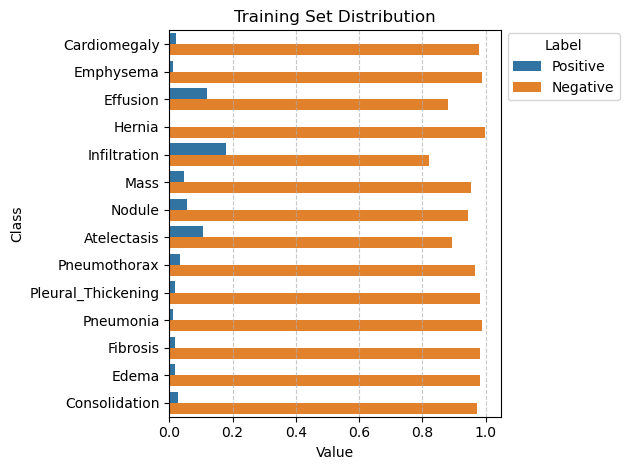

In [23]:
plot_label_distribution(train_dist, title="Training Set Distribution")

The plot highlights severe class imbalance across pathologies—e.g., Hernia has only 0.3% positives, while even the most balanced class (Infiltration) has just 17.8%.

To prevent the model from favoring the dominant class (i.e., the negative class) during training, let's assign class-specific weights—$w_{pos}$ and $w_{neg}$—so both outcomes contribute equally to the loss.

This is addressed by implementing a custom loss function based on class frequencies.

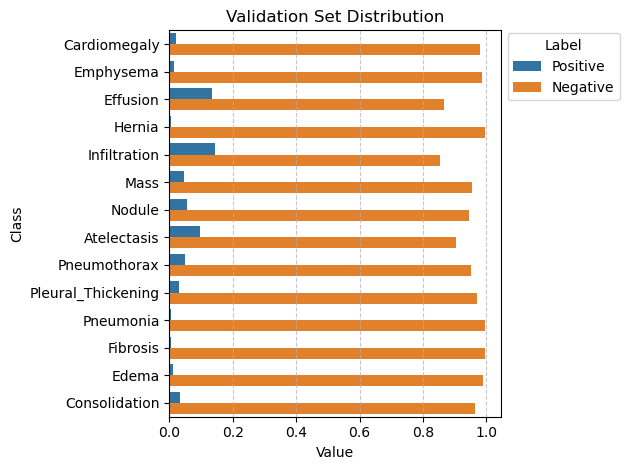

In [24]:
val_freq_pos, val_freq_neg = compute_class_freqs(valid_df[labels])
val_dist = build_label_distribution_dataframe(labels, val_freq_pos, val_freq_neg)
plot_label_distribution(val_dist, title="Validation Set Distribution")

In [25]:
val_dist.Value.values*100

array([ 2. ,  1.5, 13.5,  0.5, 14.5,  4.5,  5.5,  9.5,  5. ,  3. ,  0.5,
        0.5,  1. ,  3.5, 98. , 98.5, 86.5, 99.5, 85.5, 95.5, 94.5, 90.5,
       95. , 97. , 99.5, 99.5, 99. , 96.5])

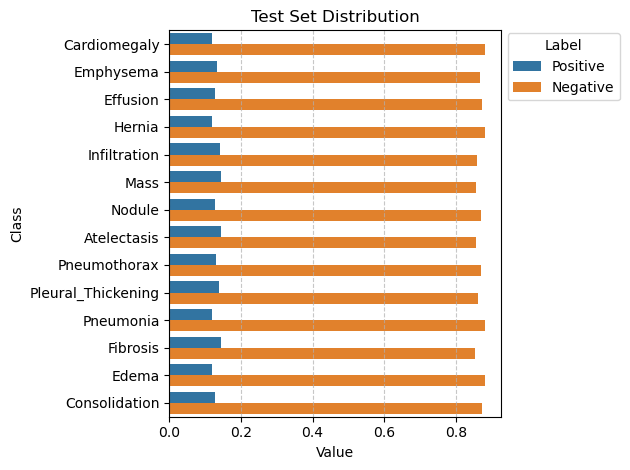

In [26]:
test_freq_pos, test_freq_neg = compute_class_freqs(test_df[labels])
test_dist = build_label_distribution_dataframe(labels, test_freq_pos, test_freq_neg)
plot_label_distribution(test_dist, title="Test Set Distribution")

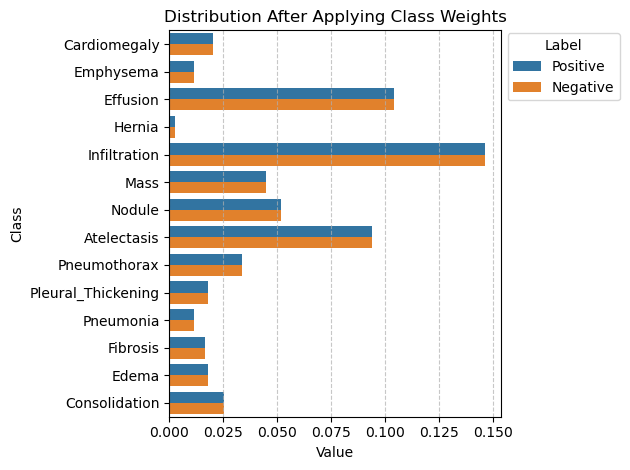

In [27]:
pos_weights = train_freq_neg
neg_weights = train_freq_pos
pos_contribution = train_freq_pos * pos_weights
neg_contribution = train_freq_neg * neg_weights

# Sanity check
weighted_train_dist = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
weighted_train_dist = pd.concat([weighted_train_dist, pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)])], ignore_index=True)

plot_label_distribution(weighted_train_dist, title="Distribution After Applying Class Weights")

Applying these class weights ensures balanced contribution from positive and negative labels.

We now implement a loss function where each training sample is scaled by its class-specific weight.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### 3.2 Get Weighted Loss


In [28]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += K.mean(-(pos_weights.iloc[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) +
                             neg_weights.iloc[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon)))
        return loss

    return weighted_loss

<a name='3-3'></a>
### 3.3 Building the Classifier with DenseNet121 as the Base Model

Let's use [DenseNet121](https://www.kaggle.com/pytorch/densenet121) as the backbone, adding a `GlobalAveragePooling2D` layer followed by a `Dense` layer with `sigmoid` activation to produce per-class prediction logits.



In [29]:
base_model = DenseNet121(weights=os.path.join(os.getcwd(), "models", "nih", "densenet.weights.h5"),
                         include_top=False)
X = base_model.output

# Add a global spatial average pooling layer
X = GlobalAveragePooling2D()(X)

# Add logistic layers for predictions
predictions = Dense(len(labels), activation="sigmoid")(X)

model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss=get_weighted_loss(pos_weights, neg_weights))

## 4. Training


In [31]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs = 3)

97/97 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - loss: 0.9663 - val_loss: 7.6801
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 0.8820 - val_loss: 1.6555
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - loss: 0.8677 - val_loss: 2.3676


In [32]:
def plot_loss_history(*histories, fig_size=(8, 5)):
    """
    Plots training and validation loss across multiple Keras training histories.

    Args:
        *histories: One or more keras.callbacks.History objects.
        fig_size (tuple): Size of the plot figure.
    """

    loss, val_loss = [], []

    for hist in histories:
        loss += hist.history.get('loss', [])
        val_loss += hist.history.get('val_loss', [])

    plt.figure(figsize=fig_size)
    plt.plot(loss, '-o', label='Train loss')
    plt.plot(val_loss, '-o', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    # plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

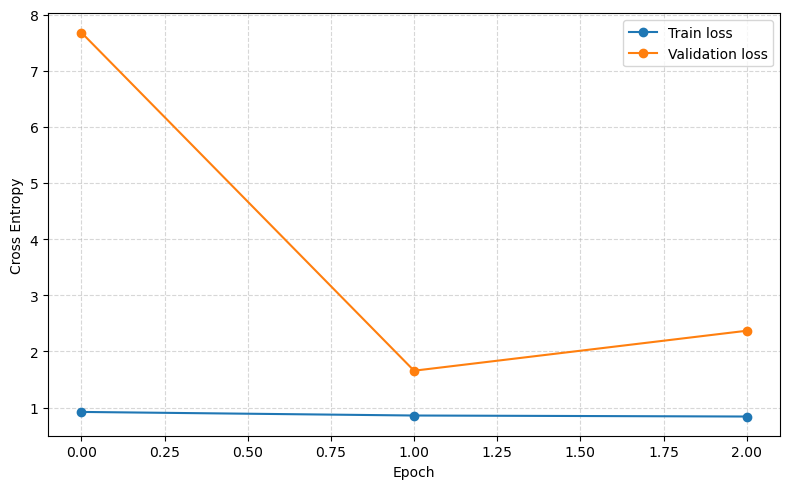

In [33]:
plot_loss_history(history)

In [35]:
# # Fine-tuning the model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#
# additional_epochs = 20
# total_epochs = 3 + additional_epochs
#
# weight_path = os.path.join(os.getcwd(), "models", "nih", "trained_model.h5")
# check_point = ModelCheckpoint(filepath=weight_path,
#                               monitor='val_loss',
#                               save_best_only=True,
#                               save_weights_only=True,
#                               verbose=0
#                               )
#
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience=5,
#                                restore_best_weights=True
#                                )
#
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=3,
#                               min_lr=1e-6
#                               )
#
# callbacks = [check_point, reduce_lr, early_stopping]
#
# history_fine = model.fit(train_generator,
#                          validation_data=valid_generator,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          callbacks=callbacks
#                          )

Training takes time. To save time, let's load pre-trained weights in the next section.

In [36]:
model.load_weights(os.path.join(os.getcwd(), "models", "nih", "pretrained_model.h5"))

## 5. Prediction and Evaluation


In [37]:
model.trainable = False
predicted_vals = model.predict(test_generator)

53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step


### 5.1 ROC Curve and AUROC
Let's briefly evaluate the model using the ROC curve and its associated metric, AUC (Area Under the Curve), also known as AUROC.

In [38]:
import inspect
functions = inspect.getmembers(med_utils, inspect.isfunction)
for name, func in functions:
    print(name)

average_precision_score
compute_gradcam
f1_score
get_accuracy
get_curve
get_false_neg
get_false_pos
get_mean_std_per_batch
get_npv
get_performance_metrics
get_ppv
get_prevalence
get_roc_curve
get_sensitivity
get_specificity
get_thresholds
get_true_neg
get_true_pos
grad_cam
load_image
plot_prc
precision_recall_curve
print_confidence_intervals
roc_auc_score
roc_curve
set_verbosity


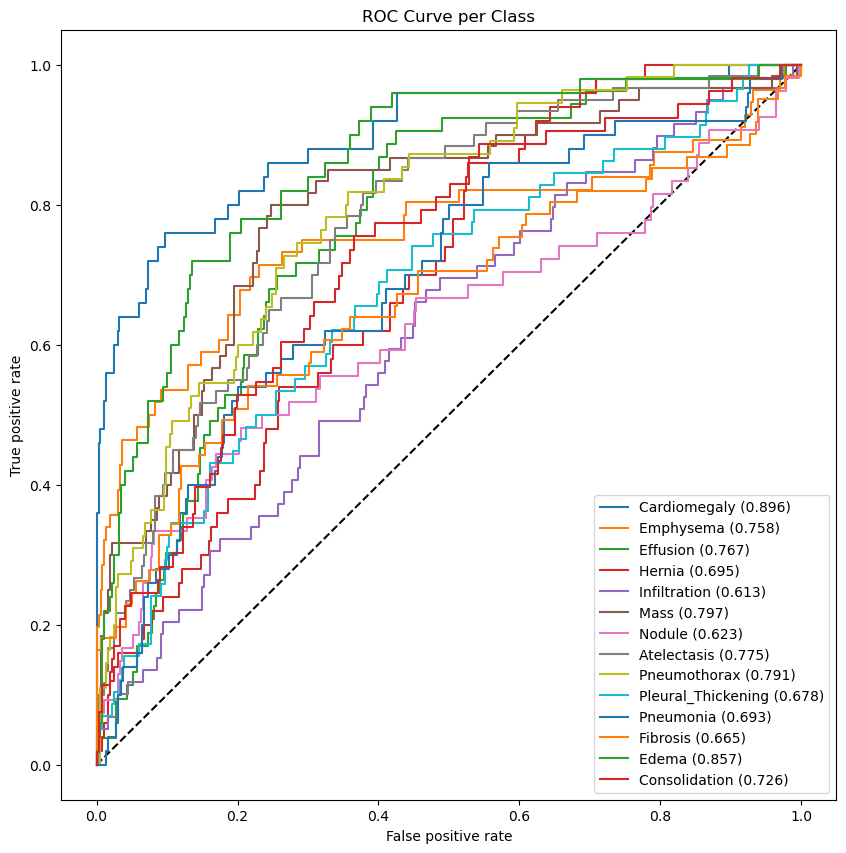

In [39]:
# Plot AUC for all labels
auc_rocs = med_utils.get_roc_curve(labels, predicted_vals, test_generator)

In [40]:
# Get the best threshold per class
y = test_df[labels].values
ths = med_utils.get_thresholds(y, predicted_vals, labels)

In [41]:
# Get performance metrics
med_utils.get_performance_metrics(y, predicted_vals, labels, thresholds=ths)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Class,,,,,,,,,,,,,
Cardiomegaly,31,358,12,19,0.926,0.119,0.620,0.721,0.721,0.950,0.896,0.667,0.740
Emphysema,26,351,13,30,0.898,0.133,0.464,0.667,0.667,0.921,0.758,0.547,0.661
Effusion,35,277,90,18,0.743,0.126,0.660,0.280,0.280,0.939,0.767,0.393,0.620
Hernia,26,274,96,24,0.714,0.119,0.520,0.213,0.213,0.919,0.695,0.302,0.450
Infiltration,39,198,163,20,0.564,0.140,0.661,0.193,0.193,0.908,0.613,0.299,0.580
Mass,48,270,90,12,0.757,0.143,0.800,0.348,0.348,0.957,0.797,0.485,0.475
Nodule,18,336,30,36,0.843,0.129,0.333,0.375,0.375,0.903,0.623,0.353,0.702
Atelectasis,30,307,53,30,0.802,0.143,0.500,0.361,0.361,0.911,0.775,0.420,0.655
Pneumothorax,27,326,39,28,0.840,0.131,0.491,0.409,0.409,0.921,0.791,0.446,0.754


In [42]:
# Get CI
from sklearn.metrics import roc_auc_score

def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, predicted_vals, labels)
med_utils.print_confidence_intervals(labels, statistics)

,Mean AUC (CI 5%-95%)
Cardiomegaly,0.896 (0.865-0.925)
Emphysema,0.760 (0.716-0.794)
Effusion,0.767 (0.734-0.803)
Hernia,0.697 (0.663-0.734)
Infiltration,0.612 (0.569-0.660)
Mass,0.798 (0.760-0.829)
Nodule,0.623 (0.580-0.667)
Atelectasis,0.777 (0.739-0.815)
Pneumothorax,0.791 (0.756-0.820)
Pleural_Thickening,0.684 (0.641-0.719)


Let's compare the performance to the AUCs reported in the original CheXNeXt paper in the table below:

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="90%">



### 5.2 Visualizing Learning with GradCAM 

Deep learning models, especially in medicine, are often difficult to interpret. To improve transparency in vision tasks, let's apply [GradCAM's](https://arxiv.org/abs/1610.02391) to visualize regions influencing the model’s decision.

Let's apply Grad-CAM to generate heatmaps that highlight image areas most relevant to each pathology prediction. It works by computing gradients flowing into the final convolutional layer. The implementation can be found in compute_gradcam within med_util.py.

While Grad-CAM doesn’t fully explain model reasoning, it’s valuable for debugging and validating whether predictions are based on clinically meaningful regions.

First, let's load the small training set and set up to examine the four classes with the highest AUC measures.

In [43]:
df = pd.read_csv(os.path.join(os.getcwd(),"data","nih","train-small-org.csv"))

# Show only the top 4 labels ranked by AUC scores.
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Now let's look at a few specific images.

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


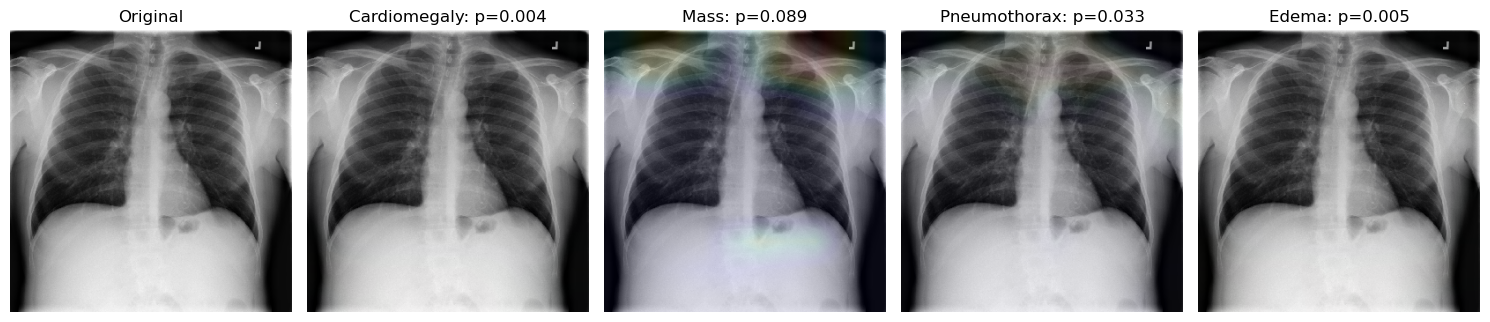

In [44]:
med_utils.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


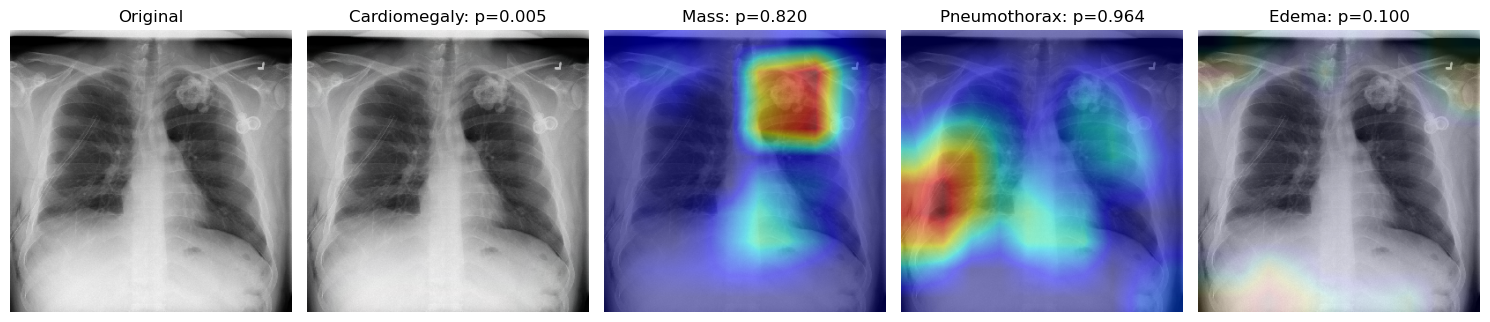

In [45]:
med_utils.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


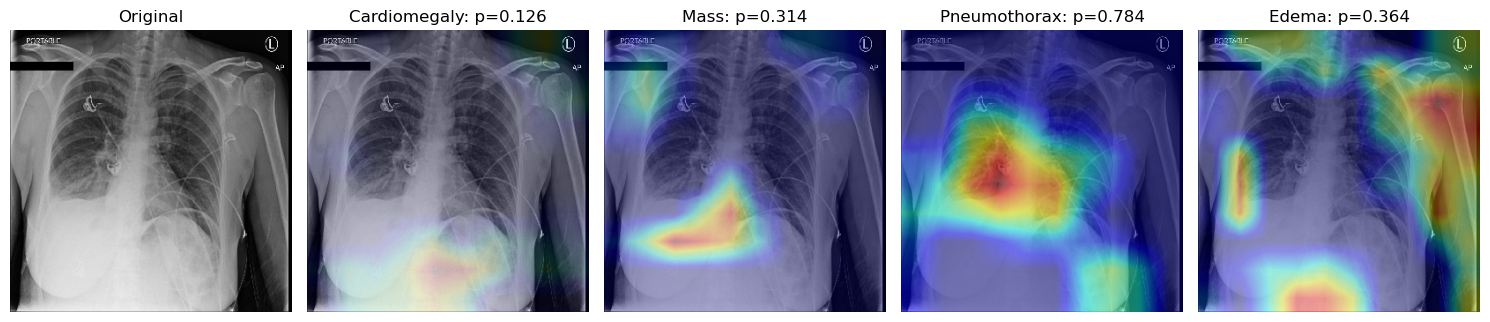

In [46]:
med_utils.compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


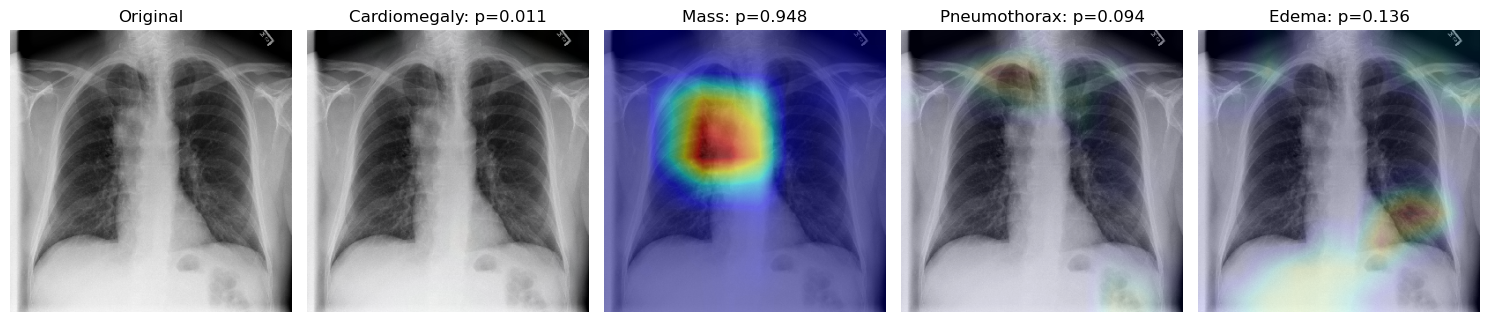

In [47]:
med_utils.compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)